In [1]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try: 
            print(f'Shape:{var.shape}')
        except : 
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}') 

In [2]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

# **실습 Class Activation Map(CAM): VGG16**

## Import module

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
import pytorch_lightning
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.lightning import LightningModule
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from IPython import display

device ='cuda:0'
torch.__version__

'1.11.0+cu113'

## For this exercise we will be using the VGG16 model

In [4]:
model = torchvision.models.vgg16(pretrained=True)  

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### Model Archtecture

In [5]:
summary(model, input_size=(8, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [8, 1000]                 --
├─Sequential: 1-1                        [8, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [8, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [8, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [8, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [8, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [8, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [8, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [8, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [8, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [8, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [8, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [8, 256, 56, 56]          29

In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Sample Image load

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


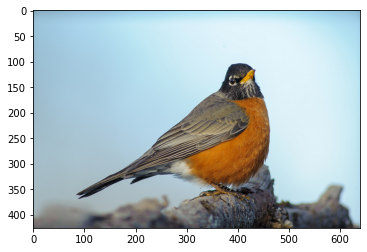

In [8]:
from PIL import Image
bird_file_path = \
  '/content/gdrive/MyDrive/Colab Notebooks/datasets/'+'bird.jpg'
img = Image.open(bird_file_path)
plt.imshow(img)  

## preporcessing

In [9]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img)          #[3,244,244]    
input_batch = input_tensor.unsqueeze(0) #[1,3,224,224] 
input_batch = input_batch.to(device)

ps(input_tensor)
ps(input_batch)

[] Shapetorch.Size([3, 224, 224])
[] Shapetorch.Size([1, 3, 224, 224])


## Prediction

In [10]:
model.eval()
logit = model(input_batch) 
prob = torch.softmax(logit, dim=1)
ps(prob)  

[] Shapetorch.Size([1, 1000])


https://pytorch.org/hub/pytorch_vision_vgg/ 

In [11]:
# Download ImageNet labels  
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-06-16 01:54:21--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-06-16 01:54:21 (109 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [12]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(prob[0], 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())  

robin 0.9993981122970581
worm fence 0.0005879128584638238
brambling 8.450175300822593e-06
water ouzel 2.438175897623296e-06
bulbul 1.9779363356065005e-06


## Build Class Activation Map 

### forward / backward Hook 

In [13]:
model._modules.get('features')  

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [14]:
model._modules.get('features')[-3]   

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html 

In [15]:
forward_features = [] # activations
backward_feature = [] # gradients

# output으로 나오는 feature를 append
def hook_feature(module, input, output):
    forward_features.append(output) #(1,512,14,14)
    ps(output,'feature'+str(len(forward_features)))

# outut으로 나오는 gradient를 append  
def backward_hook(module, input, output):
    backward_feature.append(output[0]) #((1,512,14,14),)
    ps(output[0],'gradient'+str(len(backward_feature)))

## 반복호출하면 복수의 hook가 생성됨 
model._modules.get('features')[-3].register_forward_hook(hook_feature)
model._modules.get('features')[-3].register_backward_hook(backward_hook)  

### Forward processing

In [16]:
model.eval()
logit = model(input_batch) 
t1_logit = logit[:, torch.argmax(logit)].squeeze()  
p(t1_logit)  

[feature1] Shapetorch.Size([1, 512, 14, 14])
[]:
Shape:torch.Size([])
Type: <class 'torch.Tensor'>
Values: 31.41568946838379


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [17]:
ps(forward_features[0])  

[] Shapetorch.Size([1, 512, 14, 14])


### BackPropagation

In [18]:
t1_logit.backward(retain_graph = True) #t1 값으로 backprop 
ps(backward_feature[0])  

[gradient1] Shapetorch.Size([1, 512, 14, 14])
[] Shapetorch.Size([1, 512, 14, 14])


In [19]:
features = forward_features[0]#(1,512,14,14)
gradients = backward_feature[0]  #(1,512,14,14)

### Create Heatmap  

In [20]:
b, k, h, w = gradients.size()  
# (1, 512) <= (1, 512, 14*14): feature map k_plane의'weight'  
alpha = gradients.view(b, k, -1).mean(dim=2) #dim:to reduce
ps(alpha)   #(1, 512)
weights = alpha.view(b, k, 1, 1)   
ps(weights) #(1, 512, 1, 1)  

[] Shapetorch.Size([1, 512])
[] Shapetorch.Size([1, 512, 1, 1])


In [21]:
# weights * features : (1,512,1,1)*(1,512,14,14) -> (1,1,14,14) 
grad_cam_map = (weights.cpu()*features.cpu()).sum(1, keepdim = True) 
grad_cam_map = F.relu(grad_cam_map) # Apply ReLU
ps(grad_cam_map) #(1,1,14,14)
# (14,14)->(426,640)
grad_cam_map = F.interpolate(grad_cam_map, size=(img.size[1], img.size[0]),
                             mode='bilinear', align_corners=False) 
ps(grad_cam_map) #(1, 1, 426, 640)  

[] Shapetorch.Size([1, 1, 14, 14])
[] Shapetorch.Size([1, 1, 426, 640])


In [22]:
# min-max scaling 
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data  
print(grad_cam_map.min(), grad_cam_map.max())
ps(grad_cam_map) 

tensor(0.) tensor(1.)
[] Shapetorch.Size([1, 1, 426, 640])


[] Shape(426, 640, 3), <class 'numpy.ndarray'>


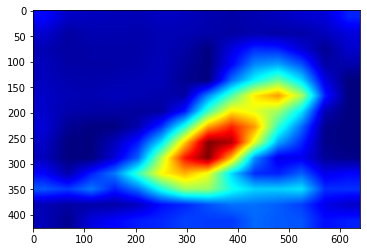

In [23]:
import cv2
# grad_cam_map.squeeze() : (224,224)<-(1,1,244,244)
grad_heatmap = cv2.applyColorMap(np.uint8(255*grad_cam_map.squeeze()),
                                 cv2.COLORMAP_JET) 
grad_heatmap = cv2.cvtColor(grad_heatmap, cv2.COLOR_RGB2BGR)
pst(grad_heatmap) #(224,244,3) 
plt.imshow(grad_heatmap)  

### Blending CAM on original image

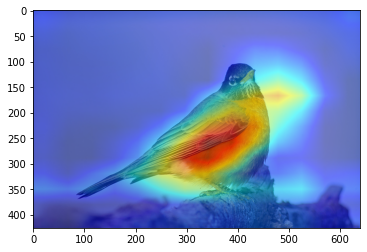

In [24]:
grad_heatmap = np.float32(grad_heatmap/255) 
_img = np.array(img)/255

grad_result = grad_heatmap + _img
grad_result = grad_result / np.max(grad_result)
grad_result = np.uint8(255 * grad_result)
plt.imshow(grad_result)  

### Trying it out on other images

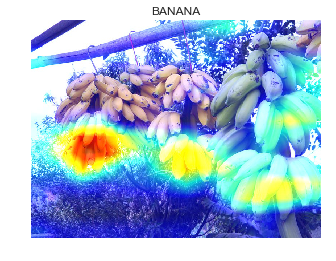

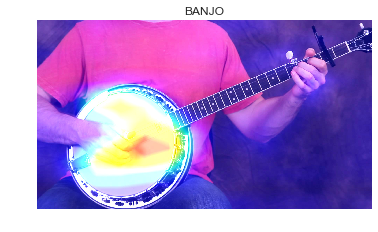

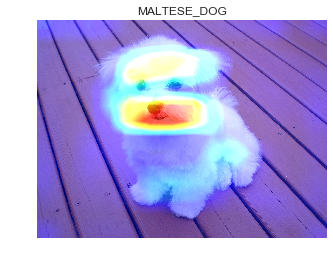

## **실습 과제**  
### **feature map을 뽑아올 위치를 바꿔보자**
#### -- feature map을 뽑아올 위치를 결정하자 
#### -- 결과를 비교해 보자 

### **inception module을 사용하여 CAM을 만들어 보자**
#### -- feature map을 뽑아올 위치를 결정하자 
#### -- 결과를 VGG16모델과 비교해 보자 
